In [37]:
"""
    radon_tx_forward_lin(m, dt, h, q; href=one(T))

Forward parabolic Radon transform (τ–q → t–h) with linear time interpolation.

Model kinematics:
    t = τ + q * (h / href)^2

Inputs:
  m    :: Matrix{T}          (nt × nq)   model in (τ, q)
  dt   :: T                  time sampling (seconds)
  h    :: Vector{T}          offsets, length nh
  q    :: Vector{T}          Radon parameters, length nq
  href :: T (keyword)        reference offset (must be ≠ 0)

Output:
  d    :: Matrix{T}          (nt × nh)   data in (t, h)
"""
function radon_tx_forward_lin(
    m::AbstractMatrix{T},
    dt::T,
    h::AbstractVector{T},
    q::AbstractVector{T};
    href::T = one(T),
) where {T<:AbstractFloat}

    nt, nq = size(m)
    nh     = length(h)

    @assert href != zero(T) "href must be non-zero when using t = τ + q*(h/href)^2"

    d = zeros(T, nt, nh)
    invdt = inv(dt)

    @inbounds for ih in 1:nh
        hr  = h[ih] / href
        hr2 = hr * hr
        for iq in 1:nq
            shift = q[iq] * hr2 * invdt      # = (q * (h/href)^2) / dt
            for itau in 1:nt
                # continuous index x in [1, nt]:
                # x = t/dt + 1 = itau + shift
                x  = itau + shift
                it = floor(Int, x)

                if it >= 1 && it < nt
                    α   = x - T(it)          # fractional part
                    val = m[itau, iq]
                    d[it,   ih] += (one(T) - α) * val
                    d[it+1, ih] += α * val
                end
            end
        end
    end

    return d
end

"""
    radon_tx_adjoint_lin(d, dt, h, q; href=one(T))

Adjoint parabolic Radon transform (t–h → τ–q) matched to `radon_tx_forward_lin`.

Computes m_adj = Aᵗ d, where A is the forward operator implemented
in `radon_tx_forward_lin`.

Inputs:
  d    :: Matrix{T}          (nt × nh)   data in (t, h)
  dt   :: T                  time sampling (seconds)
  h    :: Vector{T}          offsets, length nh
  q    :: Vector{T}          Radon parameters, length nq
  href :: T (keyword)        reference offset (must be ≠ 0)

Output:
  m    :: Matrix{T}          (nt × nq)   adjoint model in (τ, q)
"""
function radon_tx_adjoint_lin(
    d::AbstractMatrix{T},
    dt::T,
    h::AbstractVector{T},
    q::AbstractVector{T};
    href::T = one(T),
) where {T<:AbstractFloat}

    nt, nh = size(d)
    nq     = length(q)

    @assert href != zero(T) "href must be non-zero when using t = τ + q*(h/href)^2"

    m = zeros(T, nt, nq)
    invdt = inv(dt)

    @inbounds for ih in 1:nh
        hr  = h[ih] / href
        hr2 = hr * hr
        for iq in 1:nq
            shift = q[iq] * hr2 * invdt
            for itau in 1:nt
                # same continuous index as in forward
                x  = itau + shift
                it = floor(Int, x)

                if it >= 1 && it < nt
                    α = x - T(it)
                    # adjoint of the linear interp used in forward
                    m[itau, iq] += (one(T) - α) * d[it, ih] + α * d[it+1, ih]
                end
            end
        end
    end

    return
end


radon_tx_adjoint_lin

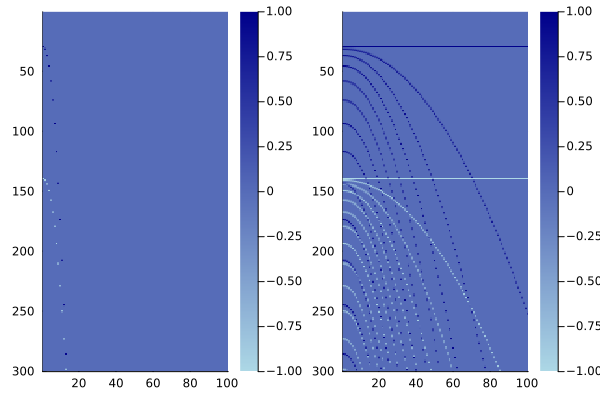

In [ ]:
using Plots
nt = 300; nq = 120; nh = 100
 q  = collect(0:1:nq-1)*0.9
 m = zeros(nt,nq); 
 m[30,80] =  1.0
 m[140,50] = -1.0
 dt = 0.004
 h  = collect(0:1:nh-1)*10.0
 d  = radon_tx_forward_lin(m, dt, h, q; href=1000.0)
 ma = radon_tx_forward_lin(d, dt, h, q; href=1000.0)
 p1 = heatmap(d,  yflip=true, cmap=:blues)
 p2 = heatmap(ma, yflip=true, cmap=:blues)

  plot(p1, p2, layout=(1,2))